<a href="https://colab.research.google.com/github/Stone-bridge-NLP/BERT/blob/main/GenreClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting environment

In [1]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 3.7 MB/s 
     |████████████████████████████████| 3.3 MB 7.9 MB/s 


In [3]:
!git clone https://github.com/Stone-bridge-NLP/BERT.git
%cd /content/BERT

Cloning into 'BERT'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
/content/BERT


In [4]:
# download shared dataset to local disk
# [차도인] [오후 9:37] https://drive.google.com/file/d/168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-/view?usp=sharing
!gdown --id 168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
FILENAME = 'preprocessed_train_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
To: /content/BERT/preprocessed_train_data.csv
100% 302M/302M [00:01<00:00, 157MB/s]


# Train model

In [5]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import utils

In [7]:
train_dataset = pd.read_csv('./'+FILENAME)
print(train_dataset)

        Genre                                             Lyrics
0        Rock  it starts with pain followed by hate fueled by...
1        Rock  freedom alone again again alone patiently wait...
2        Rock  biting the hand that feeds you lying to the vo...
3        Rock  you say you know just who i am but you can t i...
4        Rock  my heart is beating faster can t control these...
...       ...                                                ...
249943    R&B  i m the best friend he s got i d give him the ...
249944    Pop  bad boys blue i totally miss you i did you wro...
249945    Pop  forgive me for the things that i never said to...
249946  Indie  the day they found a cure for aids the day the...
249947    Pop  fourth of july has come it s custom that we go...

[249948 rows x 2 columns]


In [9]:
# Balance sampling of the DATA.
# problem here is that some genre is oversampled too much(copied 11 times)
# another problem is that this samping happens during the runtime,
# so train set and validation set is mixed up every new runtime
# ==========SOLUTION========
# First split the whole train data into 8:2 train and validation set
# to make sure they do not get mixed up
# Reduce the dataset to desired size afterwards
# 
# To prevent overcopying, start the learning with equally distributed small dataset
# Rather than overcopying, use the weighted loss
# while gradually breaking the balance by less undersampling

Genre = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
train_dataset = train_dataset[['Genre', 'Lyrics']]
train_dataset = train_dataset.drop(train_dataset[train_dataset['Genre']=='en'].index)

# portion = len(train_dataset)//(10) # 10 classes
print('====== validation set =======')
val_d = []
for genre in Genre:
  td = train_dataset[train_dataset['Genre'] == genre]
  val_d.append(td.sample(frac=0.2,random_state=31415))
  print(f'{genre}\tsample ratio\t {len(td)}:{len(val_d[-1])}')  
val_dataset = pd.concat(val_d)

train_dataset = train_dataset.drop(val_dataset.index)

train_dataset = train_dataset.reset_index().drop(columns='index')
val_dataset = val_dataset.reset_index().drop(columns='index')
    

====== validation set =======
Electronic	sample ratio	 2002:400
Country	sample ratio	 1890:378
R&B	sample ratio	 2763:553
Jazz	sample ratio	 13314:2663
Indie	sample ratio	 7240:1448
Pop	sample ratio	 86217:17243
Folk	sample ratio	 8165:1633
Metal	sample ratio	 19098:3820
Hip-Hop	sample ratio	 2238:448
Rock	sample ratio	 107016:21403


In [10]:
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      
      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      sg_tensor = torch.tensor(indexed_tokens['token_type_ids']).view(-1,2**9)
      at_tensor = torch.tensor(indexed_tokens['attention_mask']).view(-1,2**9)

    return genre, tk_tensor, sg_tensor, at_tensor



In [11]:
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()

    self.hidden_size = hidden_size

    # self.lstm1 = nn.LSTM(
    #           input_size=input_size,
    #           hidden_size=hidden_size*5,
    #           num_layers=1,
    #           dropout=0,
    #           batch_first=True)
    
    self.lstm2 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm3 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, X, seq_len):
    # X of shape N,L,Hin
    # hidden_and_cell zeros by default
    # outputs of shape N,L,Hout

    outputs, hidden_and_cell = self.lstm2(X)
    outputs, hidden_and_cell = self.lstm3(outputs)
    outputs, hidden_and_cell = self.lstm4(outputs)
    seq_len = torch.tile(seq_len.view(batch_size,1,1),(1,1,self.hidden_size))
    outputs = torch.gather(outputs,1,seq_len)
    outputs = outputs[:,-1]  # last hidden Layer of shape N,Hout
    return self.dense(outputs) # return of shape N,n_class

In [21]:
#### hyperparameters ####
epoch = 18
lr = 0.001
batch_size = 128
num_sentences = 1 # one sentence has 512 tokens
hidden_size = 128
num_layers = 1
dropout = 0.3
save_epoch = 1
save_path = 'checkpoint.pth'
epoch_start = 0
dataset_fraction = 0.15

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [22]:
# load pretrained BERT tokenizer and bare BERT model
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)

# undersample the dataset to desired size
reduced_train_dset,tr_loss_coef = utils.dfRandomSample(train_dataset,dataset_fraction)
reduced_val_dset, vl_loss_coef = utils.dfRandomSample(val_dataset,dataset_fraction)

# declare torch.utils.data.Dataset
train_set = LyricsAndGenreDataset(reduced_train_dset,tokenizer,num_sentences)
val_set = LyricsAndGenreDataset(reduced_val_dset,tokenizer,num_sentences)

# train and validation data loader
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

lstm_classifier = TextLSTM(v_dim, hidden_size, n_genre, dropout).to(device)

# load model if possible
try:
  cp = torch.load(save_path)
  epoch_start= cp['current_epoch']+1
  lstm_classifier.load_state_dict(cp['model'])
  print(f'\nsavefile from {save_path} loaded')
except FileNotFoundError:
  print('\nno savefile to load')

print(lstm_classifier)
print(sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad))
loss_func = nn.CrossEntropyLoss(reduction='none')
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

Country	 sample ratio	 1512:1512
Electronic	 sample ratio	 1602:1602
Hip-Hop	 sample ratio	 1790:1790
R&B	 sample ratio	 2210:2210
Indie	 sample ratio	 5792:3813
Folk	 sample ratio	 6532:3813
Jazz	 sample ratio	 10651:3813
Metal	 sample ratio	 15278:3813
Pop	 sample ratio	 68974:3813
Rock	 sample ratio	 85613:3814
Total size : 29993

Country	 sample ratio	 378:378
Electronic	 sample ratio	 400:400
Hip-Hop	 sample ratio	 448:448
R&B	 sample ratio	 553:553
Indie	 sample ratio	 1448:953
Folk	 sample ratio	 1633:953
Jazz	 sample ratio	 2663:953
Metal	 sample ratio	 3820:953
Pop	 sample ratio	 17243:953
Rock	 sample ratio	 21403:954
Total size : 7498


savefile from checkpoint.pth loaded
TextLSTM(
  (lstm2): LSTM(768, 512, batch_first=True)
  (lstm3): LSTM(512, 256, batch_first=True)
  (lstm4): LSTM(256, 128, batch_first=True)
  (dense): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )

In [23]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []


for e in range(epoch_start, epoch, 1):
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    loss_coef = torch.tensor(
        [tr_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

    embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)

    output = lstm_classifier.forward(embedded_tokens, seq_len)

    optimizer.zero_grad()
    loss = torch.mean(loss_coef*loss_func(output, label_batch))
    loss.backward()
    optimizer.step()
    
    if b%4 == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))

      print(f'\rTRAIN: epoch {e} batch {b}\
       loss {train_loss_list[-1]}\t acc {train_acc_list[-1]}', end='\t')

  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)
    at_batch = batch[3].to(device)

    seq_len = np.sum(at_batch.detach().cpu().numpy(), axis=(1,2)) - 1
    seq_len = torch.LongTensor(seq_len).to(device)

    loss_coef = torch.tensor(
        [vl_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = bert_embedding(
          tk_batch.view(-1,2**9), 
          token_type_ids= sg_batch.view(-1,2**9),
          attention_mask=at_batch.view(-1,2**9))

      embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

      output = lstm_classifier.forward(embedded_tokens, seq_len)

      optimizer.zero_grad()
      loss = torch.mean(loss_coef*loss_func(output, label_batch))
    

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    print(f'\rVAL: epoch {e} batch {b}\
       loss {val_loss_list[-1]}\t acc {val_acc_list[-1]}', end='\t')

  if e%save_epoch == 0:
    utils.save_checkpoint(e,lstm_classifier,save_path)

VAL: epoch 17 batch 57       loss 1.922933298227051	 acc 0.4375	

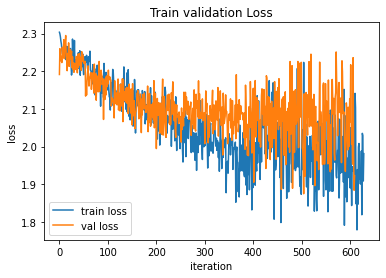

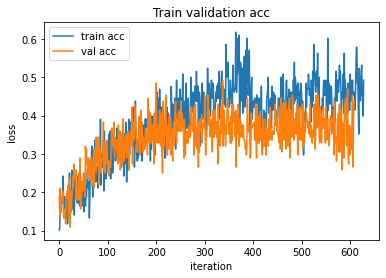

In [24]:
import matplotlib.pyplot as plt


tll = np.load('train_loss_list.npy')
vll = np.load('val_loss_list.npy')
tal = np.load('train_acc_list.npy')
val = np.load('val_acc_list.npy')

train_loss_list = tll.tolist() + train_loss_list
val_loss_list = vll.tolist() + val_loss_list
train_acc_list = tal.tolist() + train_acc_list
val_acc_list = val.tolist() + val_acc_list



plt.title('Train validation Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.legend()
plt.show()


plt.title('Train validation acc')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(train_acc_list, label='train acc')
plt.plot(val_acc_list, label='val acc')
plt.legend()
plt.show()

In [25]:
np.save('train_loss_list.npy',train_loss_list)
np.save('val_loss_list.npy',val_loss_list)
np.save('train_acc_list.npy',train_acc_list)
np.save('val_acc_list.npy',val_acc_list)